# Trip-Level Machine Learning and SHAP Analysis

In [1]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# font
plt.rcParams['font.sans-serif'] = ['Arial']
LABEL_FONT = {
    "fontsize": 12,
    "weight": "bold",
}    

# colors
BLUE = '#2878B5'
LIGHTBLUE = '#9AC9DB'
ORANGE = '#F8AC8C'
RED = '#C82423'
PINK = '#FF8884'
GREY = '#9E9E9E'
DEEPGREEN = '#32B897'
GREEN = '#96CCCB'

plt.rcParams['figure.dpi'] = 300

## 1 Data

In [3]:
import pickle
with open("Z://Data/NEE_Chengdu/agg/agg_trip_20161120.pkl", 'rb') as f:
    agg_trip = pickle.load(f)

# cleaning
agg_trip = agg_trip[agg_trip['mileage'] <= 0.6].copy()
agg_trip = agg_trip[agg_trip['brakeCount'] > 0].copy()
agg_trip = agg_trip[agg_trip['brakeEventNum'] > 0].copy()
agg_trip = agg_trip[agg_trip['initSpeed_mean'] <= 120].copy()
agg_trip = agg_trip[agg_trip['acc_mean'] >= -1].copy()
agg_trip = agg_trip[agg_trip['brakeDecel_mean'] <= 3].copy()
agg_trip = agg_trip[(agg_trip['VSP_mean'] >= -15) & (agg_trip['VSP_mean'] <= 25)].copy()
agg_trip = agg_trip[agg_trip['brakingFreq'] <= 140].copy()

# calculation
agg_trip['brakeTime_mean'] = agg_trip['brakeCount'] / agg_trip['brakeEventNum']  # sec
import numpy as np
OpModeERs = np.load("./data/agg/OpModeERs.npy")
agg_trip['ER'] = agg_trip.apply(lambda x: sum(x['OpModeCount'] / x['trajCount'] * OpModeERs), axis=1)  # g/hr/veh
agg_trip['EF'] = agg_trip.apply(lambda x: x['ER'] * (x['trajCount'] / 3600) / x['mileage'] * 1000, axis=1)  # mg/km/veh
agg_trip.shape

(1108619, 27)

In [4]:
# training data
data = agg_trip[[
    'speed_mean', 'speed_std',
    'acc_mean', 'acc_std',
    'VSP_mean', 'VSP_std',
    'brakeDecel_mean', 'brakeTime_mean', 'brakingFreq', 'initSpeed_mean',
    'grade_mean', 'grade_std', 'idlingFrac',
    'EF'
]]
data.reset_index(drop=True, inplace=True)

<Axes: >

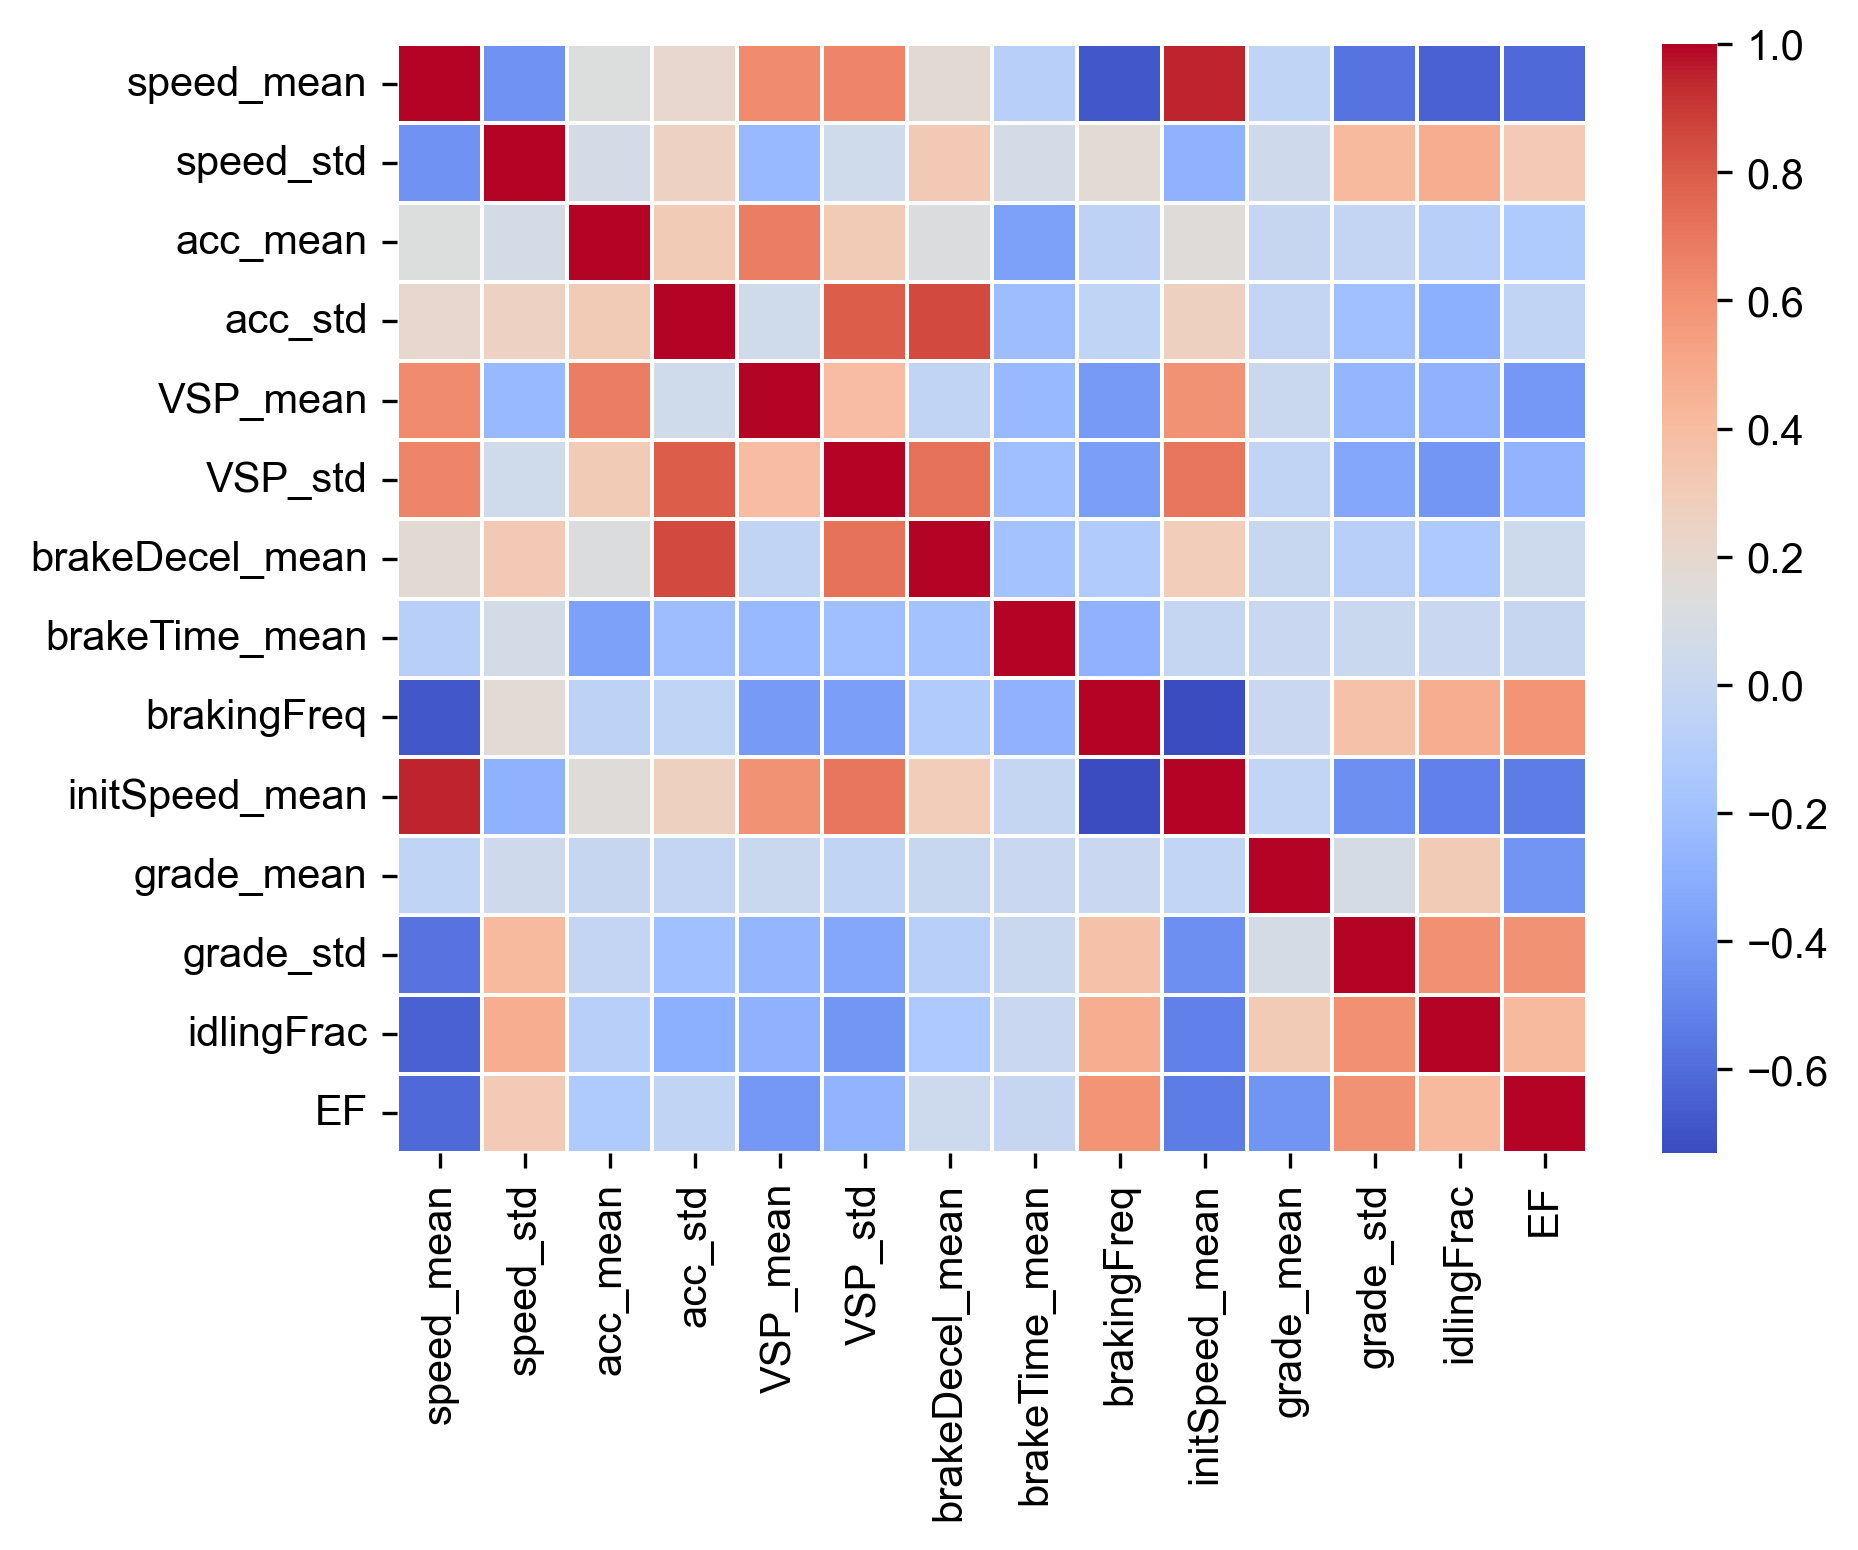

In [5]:
# correlation
import seaborn as sns
sns.heatmap(
    data.corr(),
    linewidths=0.5,
    cbar=True, cmap='coolwarm'
)

## 2 Modeling

In [159]:
from sklearn.model_selection import train_test_split
X, Y = data.iloc[:, :-1], data['EF']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('X training:', X_train.shape, 'X testing:', X_test.shape)

X training: (886895, 13) X testing: (221724, 13)


In [161]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

Parameters of XGBoost:
- General params:
  - `n_estimators`
  - `eta`: learning rate
- Tree booster params:
  - `max_depth`: max depth of a tree (default=6, range[0,inf]).
  - `min_child_weight`: minimum sum of instance weight (hessian) needed in a child. The larger `min_child_weight` is, the more conservative the algorithm will be (default=1, range[0, inf]).
  - `gamma`: minimum loss reduction required to make a partition. The larger gamma is, the more conservative the algorithm will be (default=0, range[0,inf]).
  - `subsample`: subsample ratio of the training instances (0,1].
  - `colsample_bytree`: the subsample ratio of columns when constructing each tree. (0,1].

Performance metrics:
- `RMSE`
- `R2`

### Step 1: tuning tree-based params

In [ ]:
# XGBoost
import xgboost as xgb
best_params = {}

# set param grid
params = {
    'max_depth': [6, 7, 8],
    'min_child_weight': [1, 3, 5],
}
# initialize regressor and gridsearch
reg = xgb.XGBRegressor(
    eta=0.1, n_estimators=50, seed=42
)
gs = GridSearchCV(
    reg, param_grid=params, scoring='r2', cv=10, verbose=1,
).fit(X_train, y_train)

# update best params
best_params.update(gs.best_params_)

# output info
y_pred = gs.best_estimator_.predict(X_test)
print("Best params:", gs.best_params_, "\nValidate R2: %.3f" % gs.best_score_)
print("Test R2: %.3f" % r2_score(y_test, y_pred))
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(y_test, y_pred)))

### Step2: tuning gamma

In [ ]:
# set param grid
params = {
    'gamma': [0, 1, 2, 3],
}
# initialize regressor and gridsearch
reg = xgb.XGBRegressor(
    eta=0.1, n_estimators=50, seed=42,
    max_depth=best_params['max_depth'], min_child_weight=best_params['min_child_weight'],
)
gs = GridSearchCV(
    reg, param_grid=params, scoring='r2', cv=10, verbose=1,
).fit(X_train, y_train)

# update best params
best_params.update(gs.best_params_)

# output info
y_pred = gs.best_estimator_.predict(X_test)
print("Best params:", gs.best_params_, "\nValidate R2: %.3f" % gs.best_score_)
print("Test R2: %.3f" % r2_score(y_test, y_pred))
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(y_test, y_pred)))

### Step3: tuning `subsample` and `colsample_bytree`

In [ ]:
# set param grid
params = {
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}
# initialize regressor and gridsearch
reg = xgb.XGBRegressor(
    eta=0.1, n_estimators=50, seed=42,
    max_depth=best_params['max_depth'], min_child_weight=best_params['min_child_weight'],
    gamma=best_params['gamma']
)
gs = GridSearchCV(
    reg, param_grid=params, scoring='r2', cv=10, verbose=1,
).fit(X_train, y_train)

# update best params
best_params.update(gs.best_params_)

# output info
y_pred = gs.best_estimator_.predict(X_test)
print("Best params:", gs.best_params_, "\nValidate R2: %.3f" % gs.best_score_)
print("Test R2: %.3f" % r2_score(y_test, y_pred))
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(y_test, y_pred)))

### Step4: tuning `eta` and `n_estimators`

In [ ]:
# set param grid
params = {
    'eta': [0.01, 0.05],
    'n_estimators': [500, 1000],
}
# initialize regressor and gridsearch
reg = xgb.XGBRegressor(
    eta=0.1, n_estimators=50, seed=42,
    max_depth=best_params['max_depth'], min_child_weight=best_params['min_child_weight'],
    gamma=best_params['gamma'],
    subsample=best_params['subsample'], colsample_bytree=best_params['colsample_bytree']
)
gs = GridSearchCV(
    reg, param_grid=params, scoring='r2', cv=10, verbose=1,
).fit(X_train, y_train)

# update best params
best_params.update(gs.best_params_)

# output info
y_pred = gs.best_estimator_.predict(X_test)
print("Best params:", gs.best_params_, "\nValidate R2: %.3f" % gs.best_score_)
print("Test R2: %.3f" % r2_score(y_test, y_pred))
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
best_params

### best model

In [49]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    eta=0.05,
    max_depth=10,
    min_child_weight=7,
    gamma=0,
    subsample=0.8,
    colsample_bytree=1.0,
    reg_alpha=10
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric=None,
             feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=7, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [50]:
xgb_model.save_model("./data/shap/best_model_EF.json")

In [51]:
from sklearn.metrics import mean_squared_error, r2_score
R2_train = r2_score(y_train, xgb_model.predict(X_train))
R2_test = r2_score(y_test, xgb_model.predict(X_test))
RMSE_train = np.sqrt(mean_squared_error(y_train, xgb_model.predict(X_train)))
RMSE_test = np.sqrt(mean_squared_error(y_test, xgb_model.predict(X_test)))
R2 = r2_score(Y, xgb_model.predict(X))
RMSE = np.sqrt(mean_squared_error(Y, xgb_model.predict(X)))
print("Train R2: %.4f, RMSE: %.4f" % (R2_train, RMSE_train))
print("Test R2: %.4f, RMSE: %.4f" % (R2_test, RMSE_test))
print("Overall R2: %.4f, RMSE: %.4f" % (R2, RMSE))

Train R2: 0.9774, RMSE: 6.7588
Test R2: 0.9540, RMSE: 9.5400
Overall R2: 0.9728, RMSE: 7.3992


In [52]:
y_pred = xgb_model.predict(X)

import pandas as pd
pred_results =pd.DataFrame({"index":Y.index,"true": Y, "pred":y_pred})
pred_results.sort_values(by='true', inplace=True)

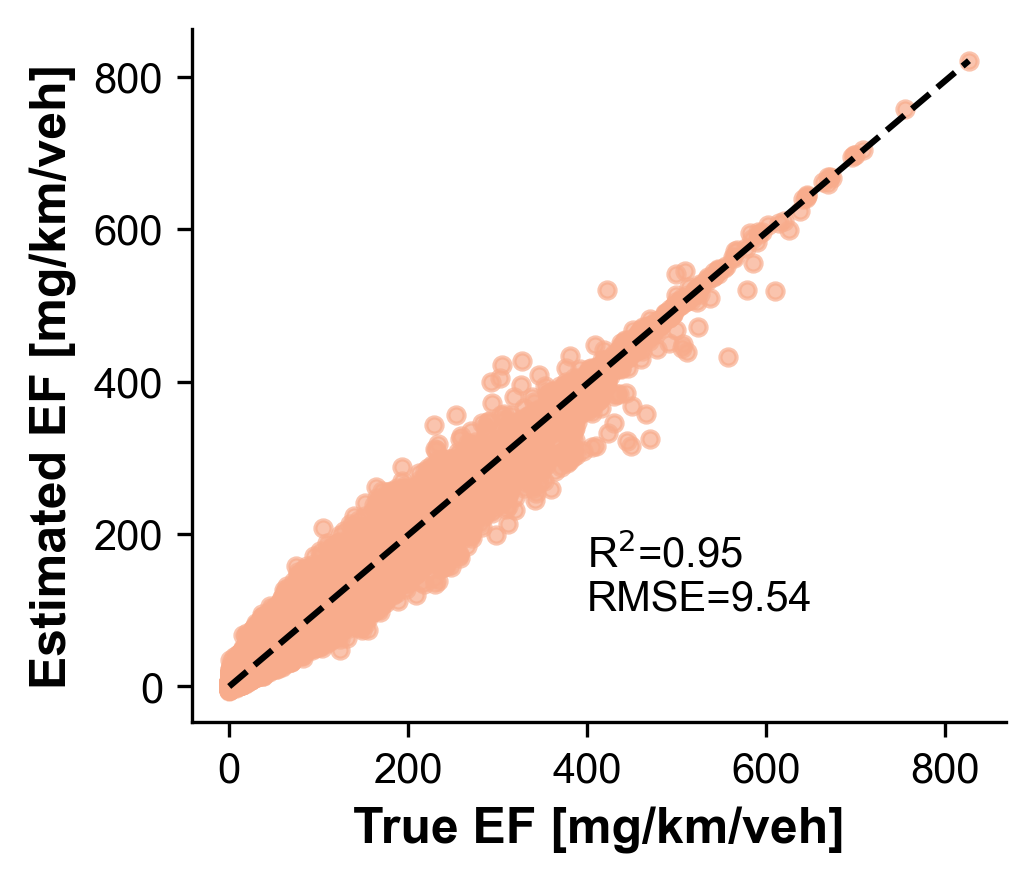

In [53]:
fig, ax = plt.subplots(1,1,figsize=(3.5,3))

ax.scatter(pred_results['true'], pred_results['pred'], s=15, c=ORANGE, marker='o', alpha=0.7)
ax.plot([0, pred_results['true'].max()], [0, pred_results['pred'].max()], 'k--')

ax.text(400, 100, 'R$^2$=%.2f\nRMSE=%.2f' % (R2_test, RMSE_test))

ax.set_yticks(np.arange(0, 810, 200))
ax.set_xlabel("True EF [mg/km/veh]", fontdict=LABEL_FONT)
ax.set_ylabel("Estimated EF [mg/km/veh]", fontdict=LABEL_FONT)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## 3 SHAP

### Feature importance

In [3]:
data = agg_trip[[
    'speed_mean', 'speed_std',
    'acc_mean', 'acc_std',
    'VSP_mean', 'VSP_std',
    'brakeDecel_mean', 'brakeTime_mean', 'brakingFreq', 'initSpeed_mean',
    'grade_mean', 'grade_std', 'idlingFrac',
    'EF'
]].sample(100000, random_state=42)
data.reset_index(drop=True, inplace=True)
X, Y = data.iloc[:, :-1], data['EF']

import xgboost as xgb
xgb_model = xgb.Booster()
xgb_model.load_model("./data/shap/best_model_EF.json")

# generate explainer
import shap
explainer = shap.TreeExplainer(xgb_model)

import numpy as np
shapV = np.load("./data/shap/shap_value_EF.npy")

In [4]:
names = ['avg. speed', 'speed std.',
        'avg. acc', 'acc std.',
        'avg. VSP', 'VSP std.',
        'avg. decel. of braking', 'avg. braking time', 'braking freq.', 'avg. init. speed',
        'avg. grade', 'grade std.', 'idling frac.']
shapDF = pd.DataFrame(shapV, columns=names)

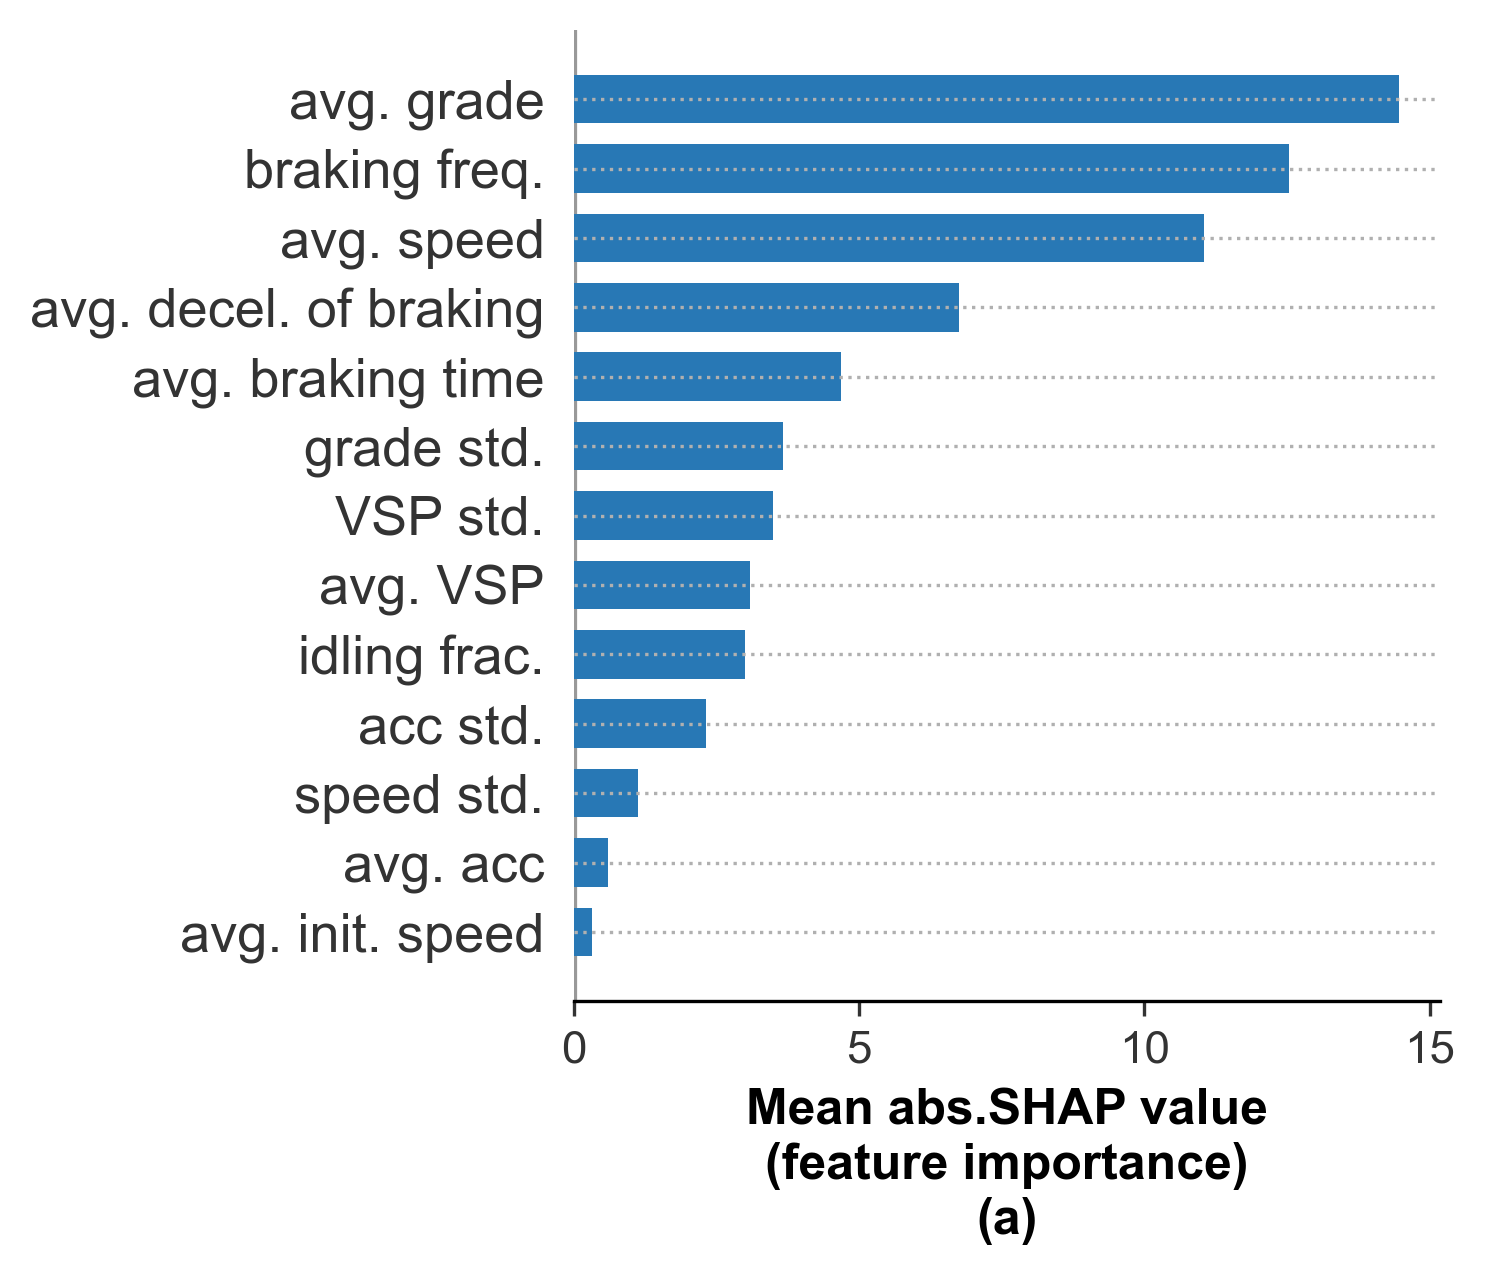

In [58]:
size = (5,4)
f = plt.figure(figsize=size)
shap.summary_plot(
    shapV, X, plot_type="bar", feature_names=names,
    color=BLUE, plot_size=size, show=False)
plt.xlabel("Mean abs.SHAP value\n(feature importance)\n(a)", fontdict=LABEL_FONT)
plt.grid(axis='y', linestyle=":", zorder=-1)
plt.show()

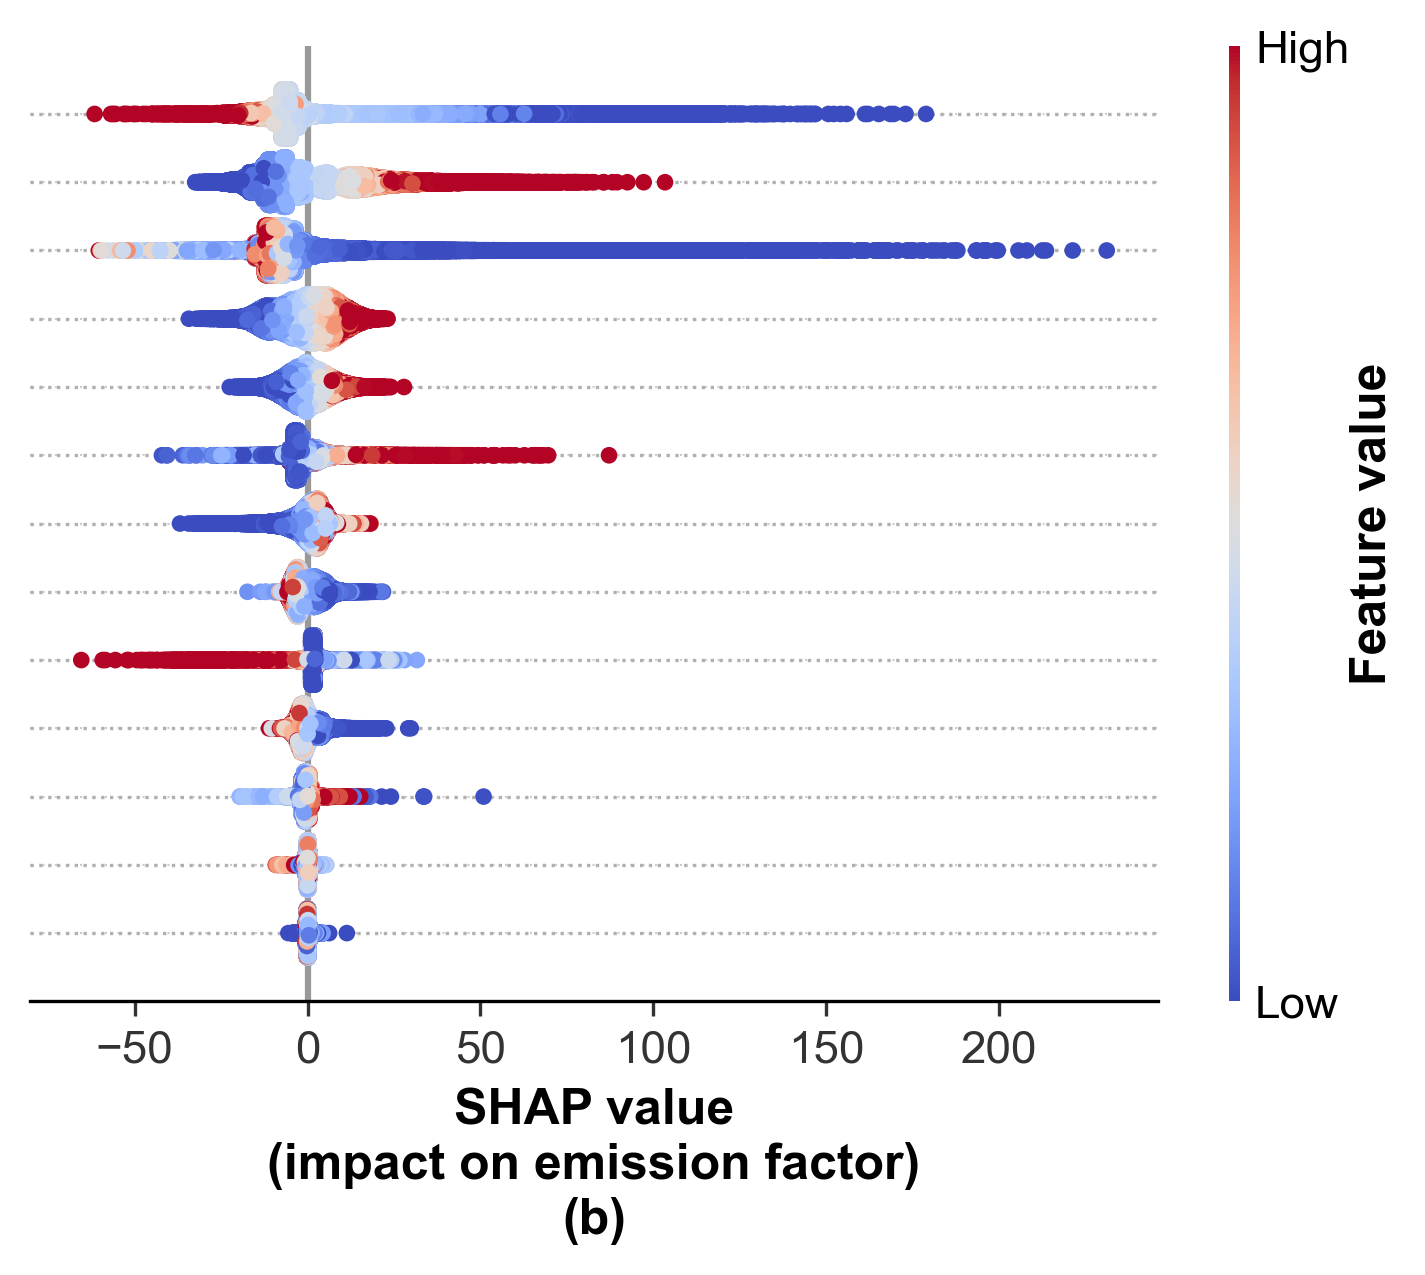

In [62]:
size = (5,4)
f = plt.figure(figsize=size)
shap.summary_plot(
    shapV, X, plot_type='dot', feature_names=["" for n in names],
    plot_size=size, show=False, cmap='coolwarm'
)
plt.xlabel("SHAP value\n(impact on emission factor)\n(b)", fontdict=LABEL_FONT)
cbar = plt.gcf().axes[-1]
cbar.set_ylabel('Feature value', fontdict=LABEL_FONT)
plt.grid(axis='y', linestyle=":", zorder=-1)
plt.show()


### Dependence

In [6]:
# obtain bins for ER
speedBins = np.arange(0, 110, 10)
initSpeedBins = np.arange(0, 140, 20)
accBins = np.arange(-10, 16, 5) / 10
VSPBins = np.arange(-15, 30, 5)
decelBins = np.arange(0, 2.5, 0.3)
brakeDecelBins = np.arange(0, 28, 3) / 10
brakeFracBins = np.arange(0, 1.2, 0.2)
idleFracBins = np.arange(0, 1.2, 0.2)
gradeBins = np.arange(-2, 2, 1) / 100

def binCal(xCol, yCol, bins, aggFile):
    mean = [aggFile[(aggFile[xCol] >= minV) & (aggFile[xCol] < maxV)][yCol].mean() for minV, maxV in zip(bins[:-1], bins[1:])]
    std = [aggFile[(aggFile[xCol] >= minV) & (aggFile[xCol] < maxV)][yCol].std() for minV, maxV in zip(bins[:-1], bins[1:])]
    
    return mean, std

def distPlot(ax, xCol, binwidth, color, xLabel, subID, aggFile, hline=True):
    sns.histplot(
        aggFile, y=xCol, binwidth=binwidth, stat='proportion',
        element='bars', fill=False, hatch='//', color=color, alpha=0.6, ax=ax
    )
    if hline:
        ax.hlines(
            aggFile[xCol].mean(), 0, ax.get_xbound()[1],
            colors='k', linestyles='dashed',
            label='Mean = %.2f' % aggFile[xCol].mean()
        )
        ax.legend()
    ax.set_xlabel("Proportion\n(%s)"%(subID) if subID else "Proportion", fontdict=LABEL_FONT)
    ax.set_ylabel(xLabel, fontdict=LABEL_FONT)

    return ax

def corrPlot(ax, xCol, yCol, bins, xLabel, yLabel, subID, cmap, aggFile, histBinNum=30):
    # hist plot
    sns.histplot(
        aggFile, x=xCol, y=yCol, bins=histBinNum, stat='proportion', ax=ax,
        fill=True, cmap=cmap, cbar=True, cbar_kws=dict(location='right', shrink=0.8, label="Proportion"),
        )
    binMean, binStd =binCal(xCol, yCol, bins, aggFile=aggFile)
    ax.errorbar(
        bins[:-1]+(bins[1]-bins[0])/2, binMean, binStd,
        color='k', linestyle='dotted', linewidth=1, markerfacecolor='w', marker='d', alpha=0.8,
        label="Average"
    )
    ax.set_xticks(bins)
    ax.set_xlabel("%s\n(%s)"%(xLabel, subID) if subID else xLabel, fontdict=LABEL_FONT)
    ax.set_ylabel(yLabel, fontdict=LABEL_FONT)
    ax.legend()
    ax.grid(axis='x', linestyle=":")

    return ax

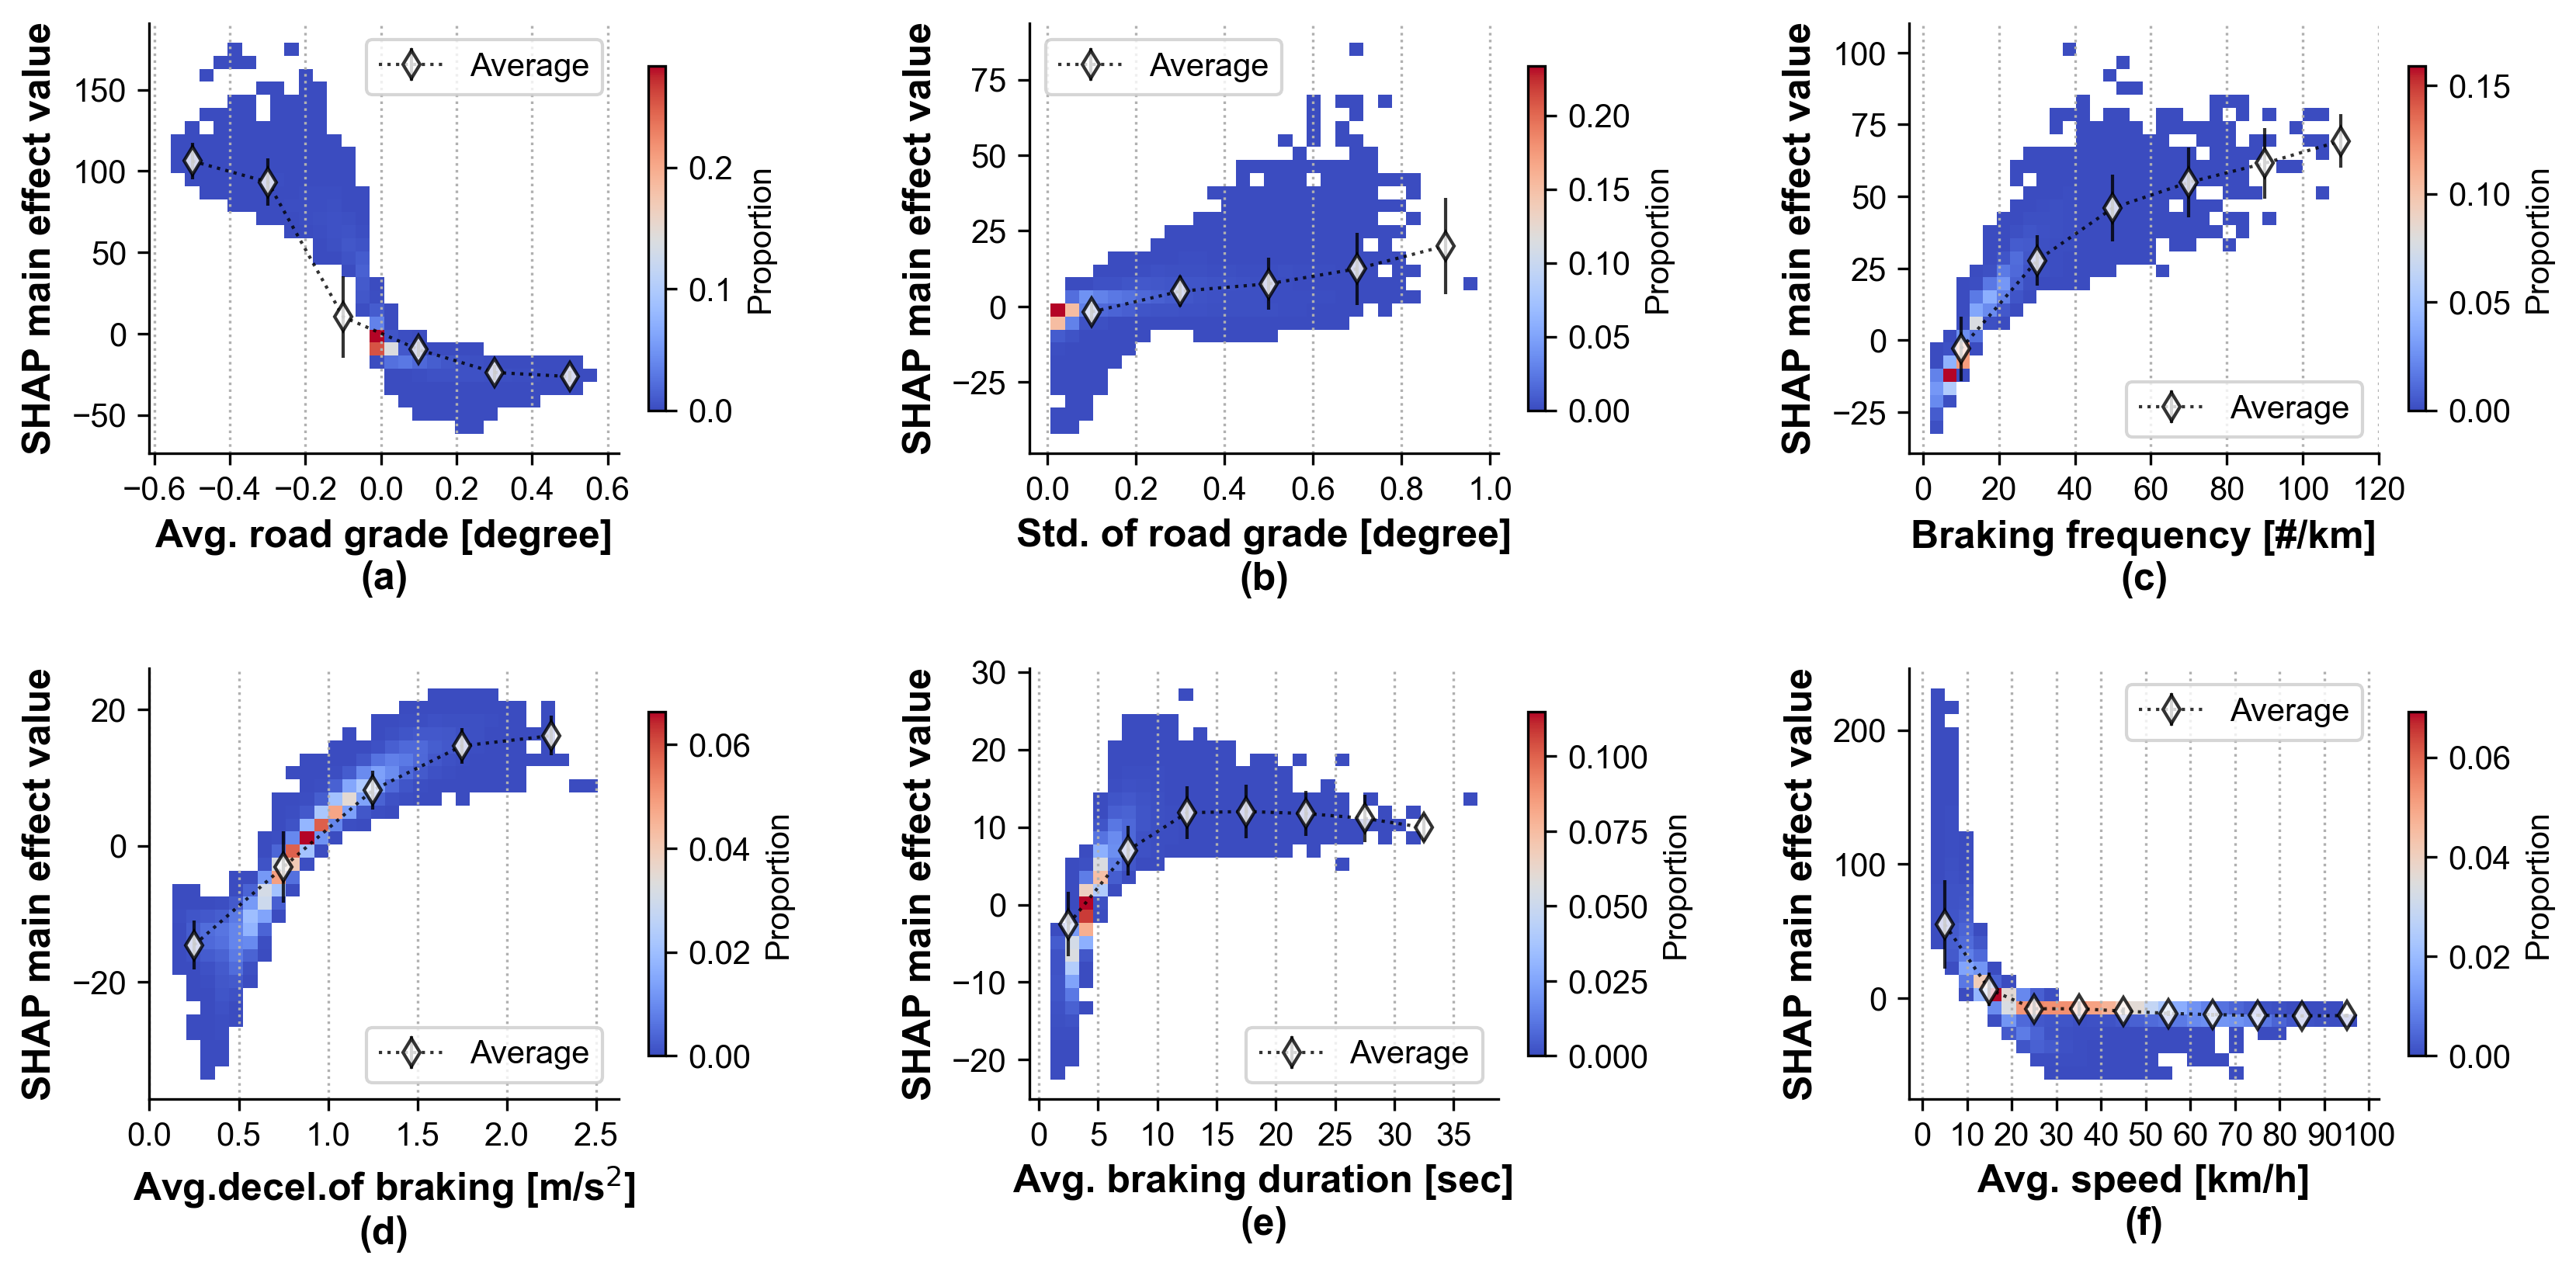

In [8]:
shapDF = pd.DataFrame(shapV, columns=[n+'_shap' for n in X.columns])
shapDF = pd.merge(shapDF, X, left_index=True, right_index=True)

fig, ax = plt.subplots(2,3,figsize=(13,6))
ax = ax.flatten()

ax[0] = corrPlot(
    ax[0], xCol='grade_mean', yCol='grade_mean_shap', xLabel="Avg. road grade [degree]", yLabel="SHAP main effect value",bins=np.arange(-6,7,2)/10,
    subID='a', cmap='coolwarm', aggFile=shapDF
)

ax[1] = corrPlot(
    ax[1], xCol='grade_std', yCol='grade_std_shap', xLabel="Std. of road grade [degree]", yLabel="SHAP main effect value",bins=np.arange(0,11,2)/10,
    subID='b', cmap='coolwarm', aggFile=shapDF)
ax[1].legend(loc=2)

ax[2] = corrPlot(
    ax[2], xCol='brakingFreq', yCol='brakingFreq_shap', xLabel="Braking frequency [#/km]", yLabel="SHAP main effect value",bins=np.arange(0,140,20),
    subID='c', cmap='coolwarm', aggFile=shapDF)
ax[2].legend(loc=4)

ax[3] = corrPlot(
    ax[3], xCol='brakeDecel_mean', yCol='brakeDecel_mean_shap', xLabel="Avg.decel.of braking [m/s$^2$]", yLabel="SHAP main effect value",bins=np.arange(0,26,5)/10,
    subID='d', cmap='coolwarm', aggFile=shapDF)
ax[3].legend(loc=4)

ax[4] = corrPlot(
    ax[4], xCol='brakeTime_mean', yCol='brakeTime_mean_shap', xLabel="Avg. braking duration [sec]", yLabel="SHAP main effect value",bins=np.arange(0,40,5),
    subID='e', cmap='coolwarm', aggFile=shapDF)
ax[4].legend(loc=4)

ax[5] = corrPlot(
    ax[5], xCol='speed_mean', yCol='speed_mean_shap', xLabel="Avg. speed [km/h]", yLabel="SHAP main effect value",bins=np.arange(0,110,10),
    subID='f', cmap='coolwarm', aggFile=shapDF
)


for ax_ in ax:
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)

plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5)
plt.show()